# Two-Way Shooting

This example shows how use two-way shooting in OpenPathSampling.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.engines import toy as toys

We start out by creating a simple toy potential energy surface, defining a couple of states, and creating a trajectory that connects the two states.

In [2]:
# a simple toy PES
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))
topology = toys.Topology(n_spatial=2, masses=np.array([1.0]), pes=pes)
engine = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.005, gamma=0.000001),
                      'n_frames_max': 5000,
                      'n_steps_per_frame': 10}, topology)
template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.1, 0.0]]),
                         engine=engine)

cv_x = paths.CoordinateFunctionCV("x", lambda snap: snap.xyz[0][0])
cv_y = paths.CoordinateFunctionCV("y", lambda snap: snap.xyz[0][1])
left_state = paths.CVDefinedVolume(cv_x, lambda_min=float("-inf"), lambda_max=-0.3)
right_state = paths.CVDefinedVolume(cv_x, lambda_min=0.3, lambda_max=float("inf"))
network = paths.TPSNetwork(left_state, right_state)

# a fake trajectory
fw_shot = engine.generate(template, paths.AllOutXEnsemble(left_state | right_state))
bw_shot = engine.generate(template.reversed, paths.AllOutXEnsemble(left_state | right_state))
trajectory = bw_shot.reversed + fw_shot[1:]

initial_conditions = paths.SampleSet([
    paths.Sample(replica=0,
                 ensemble=network.sampling_ensembles[0],
                 trajectory=trajectory)
])

(-0.5, 0.5)

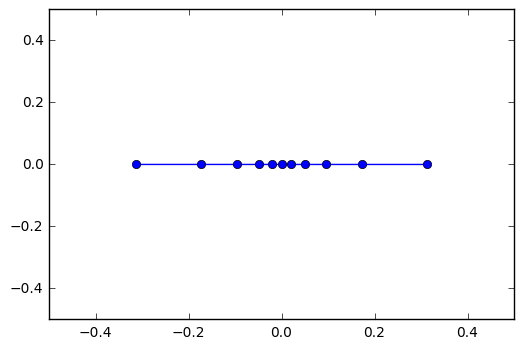

In [3]:
plt.plot(cv_x(trajectory), cv_y(trajectory), '-o')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

## Shooting point modifiers

One of the things that distinguishes two-way shooting from one-way shooting is that two-way shooting involves modifying the shooting point snapshot. There are a lot of options for how you might change that snapshot; here we have implemented a few, and we'll show how they work.

All `SnapshotModifier`s have an initialization option `subset_mask`, which allows you to specify a subset of the total atoms that this applies to. This allows you to, for example, only change the velocities of the solute atoms. This is not illustrated for this simple model, since the 2D toy has only one (pseudo-)atom.

### "Direction" changing modifiers

Usually, when people are first introduced to path sampling (and to the shooting move in particular), they are told that you perturb the velocity at the shooting point. That's what the `VelocityDirectionModifier`s do. However, it is very hard to do this correctly in the presence of constraints, so if your system involves constraints, please use the thermal randomization approach.

There are a couple versions of velocity direction modification, although in this toy model they do the same thing:

* `VelocityDirectionModifer`: changes the direction of all atoms from the subset
* `SingleAtomVelocityDirectionModifier`: changes the direction of a randomly selected atom from the subset

In this example, we'll only use the first.

In [4]:
# in a real system, you remove linear momentum. in this toy, doing so gives velocity=0!
# the default is remove_linear_momentum=True
direction_modifier = paths.VelocityDirectionModifier(delta_v=0.04, remove_linear_momentum=False)

### Thermal randomization modifier

In [5]:
temperature = template.instantaneous_temperature  # use the temperature of the initial snapshot
thermal_randomizer = paths.RandomVelocities(beta=1.0/temperature, engine=engine)

## Manually building a two-way shooting mover

Here we will build the two-way shooting mover, and show its output, as well as how different modifiers sample differently.

In [6]:
tps_ensemble = network.sampling_ensembles[0]
dir_change_mover = paths.TwoWayShootingMover(ensemble=tps_ensemble,
                                             selector=paths.UniformSelector(),
                                             modifier=direction_modifier,
                                             engine=engine)

Now we're going to shoot several times from the same initial trajectory, to show the variety of shots we can get with this mover.

In [7]:
change = dir_change_mover.move(initial_conditions)
changes = [change] + [dir_change_mover.move(initial_conditions) for i in range(4)]

(-0.15, 0.15)

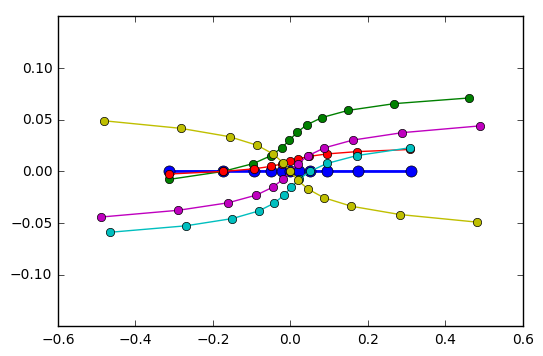

In [8]:
plt.plot(cv_x(trajectory), cv_y(trajectory), '-o', lw=2, markersize=8)
for change in changes:
    plt.plot(cv_x(change.trials[0].trajectory), cv_y(change.trials[0].trajectory), '-o')
plt.ylim(-0.15, 0.15)

Because the magnitude of the change is rather small, and because the total kinetic energy in the direction of the transition is large in the original trajectory, note that nearly all the paths make a full crossing. Now let's compare that with the thermal randomizer.

In [9]:
thermal_mover = paths.TwoWayShootingMover(ensemble=tps_ensemble,
                                          selector=paths.UniformSelector(),
                                          modifier=thermal_randomizer,
                                          engine=engine)

(-0.15, 0.15)

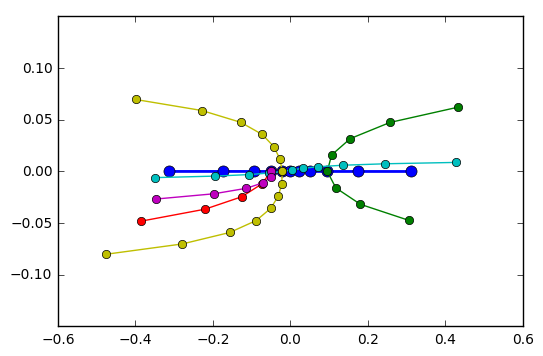

In [10]:
change = thermal_mover.move(initial_conditions)
changes = [change] + [thermal_mover.move(initial_conditions) for i in range(4)]

plt.plot(cv_x(trajectory), cv_y(trajectory), '-o', lw=2, markersize=8)
for change in changes:
    plt.plot(cv_x(change.trials[0].trajectory), cv_y(change.trials[0].trajectory), '-o')
plt.ylim(-0.15, 0.15)

Sometimes, this doesn't even get a crossing. Here you'll often see paths that only go one direction: this is because the are forward-first shots that end in the left state, or backward-first shots that end in the right state. These trajectories could never satisfy the left-to-right ensemble. You also see far more left-to-left or right-to-right paths here.

## Using the two-way shooting move strategy

As with most path movers in OpenPathSampling, the preferred way to select two-way shooting is to use its associated move strategy. This is also the easiest way. All you need to do is select an approach for the shooting point selection (`selector`) and for modifying the shooting point (`modifier`).

In [11]:
strategy = paths.strategies.TwoWayShootingStrategy(modifier=thermal_randomizer,
                                                   selector=paths.UniformSelector(),
                                                   engine=engine)

In [12]:
scheme_thermal = paths.OneWayShootingMoveScheme(
    network=network,
    selector=paths.UniformSelector(),
    engine=engine
)
scheme_thermal.append(strategy)

In [13]:
storage = paths.Storage("thermal.nc", "w")

In [14]:
simulation = paths.PathSampling(storage=storage,
                                move_scheme=scheme_thermal,
                                sample_set=initial_conditions)
simulation.run(100)

Working on Monte Carlo cycle number 100
Running for 6 seconds - 15.75 steps per second
Expected time to finish: 0 seconds
DONE! Completed 100 Monte Carlo cycles.


In [15]:
scheme_thermal.move_summary(storage.steps)
storage.close()

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 11/100 (11.00%)


This is a pretty low acceptance probability. Let's try the same, but with the direction based modifier:

In [16]:
scheme_direction = paths.OneWayShootingMoveScheme(
    network=network,
    selector=paths.UniformSelector(),
    engine=engine
)
scheme_direction.append(
    paths.strategies.TwoWayShootingStrategy(modifier=direction_modifier,
                                            selector=paths.UniformSelector(),
                                            engine=engine)
)

In [17]:
storage = paths.Storage("direction.nc", "w")

In [18]:
simulation = paths.PathSampling(storage=storage,
                                move_scheme=scheme_direction,
                                sample_set=initial_conditions)
simulation.run(100)

Working on Monte Carlo cycle number 100
Running for 9 seconds - 10.74 steps per second
Expected time to finish: 0 seconds
DONE! Completed 100 Monte Carlo cycles.


In [19]:
scheme_direction.move_summary(storage.steps)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 79/100 (79.00%)


This acceptance probability is actually too *high*. It indicates that each trajectory is probability too much like the previous trajectory. The acceptance can be decreased by increasing the delta-v.

Why is the direction-based modifier better than thermal randomization for this system? Fundamentally, the issue is that this model is very ballistic. The thermostat friction is so low that this is effectively deterministic. If the motion is ballistic, then completely randomizing your velocity is likely to do a lot of harm to your chances of getting another crossing. On the other hand, if you have diffusive dynamics, then the system will largely lose memory of the direction of your velocity in some relatively short time frame. In that case, thermal randomization should be just as good as direction modification (and it works in more situations, e.g., with constraints.)